# **The Battle of Neighbourhoods**

## <Applied Data Science Capstone project(IBM)>

Contents:

1.   Introduction (Business Problem)
2.   Data
3.   Procedure
4.   Analysis
5.   Result and Discussion
6.   Inference



### **1. Introduction (Business Problem)**

  According the latest NYC&Company release New York City welcomed about 65.2 million tourists in 2018 year - 51.6 million domestic and 13.5 million international visitors. And these numbers are continuously increasing from year to year - 
  
  The data set-https://en.wikipedia.org/wiki/Tourism_in_New_York_City

New York City has the largest selection of lodging choices in the country – from the hostels to the luxury hotels. The prices vary from 100$ till several thousand dollars with average price 292 USD per night.


The Hotel Occupancy rate is also high – in 2018 year it was 88% as seen by the data set given in the below link
 https://assets.simpleviewinc.com/simpleview/image/upload/v1/clients/newyorkcity/FYI_Hotel_reports_February_2019_8607015b-b32a-4c7f-9fbd-84cd2a93cbe6.pdf

Visitors often prefer short stays that are often over weekends - averaging 2.4 nights. This is shown in the link below
 https://aka.nyc/content/uploads/2017/12/new_york_city_travel_and_tourism_trend_report_2017.pdf

***Problem Description***

New York city has around 300 hotels with over 75,000 rooms. Airbnb has more than 50,000 apartment listings in New York City as of the year 2018. Due to this it can be hard to find the right fit or to know what one can afford. In this project we will try and find out the most optimal borough in Mahattan where tourists can rent an accomodation through Airbnb service. This will ensure that the tourist has a pleasant stay in New York and a possiblity to be near the most visited attractions like Central Park, Times Square etc.

***Target Audience***

This analysis will interest visitors or tourists of New YOrk city who prefers short stays and want to select the best neighborhoods in Manhattan, New York.

***Success Criteria***

The success criteria of this project is a recommendation with the set of apartments clusters that have the best score calculated based on

*   Cost of Accomodation
*   Location of accomodation
*   Attractions in 100m radius of the accomadtion
*   Crime rate in a radius of 100m from the accomodation

###**2. Data**

For this analysis we are using free and publicly availabel datasets.

We will find availabe Airbnb accomodations in Manhattan, New York and define the most affordable appartment clusters for tourists.

The factors that will contribute to this analysis are:


*   Average price of accomodation in the neighbourhood
*   Number of tourist attractions near the accommodation
*   Crime rate near the accomodation


The datsets for the above listed factors are available on the links given below


*   Apartment listing in New York City from *Inside Airbnb* :  http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz
*   Tabulation of New York neighbourhoods :  https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON
*   New York Crime data- https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD
*   Foursquare API to extract data about venues -museums, restaurants, art  galleries, shopping complexes, sightseeing attractions, concert stadiums etc.








###**3. Procedure**



**Importing necessary libraries**

In [ ]:
import pandas as pd # library for data analysis
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import numpy as np # library to handle data in vecorized manner

import locale
import requests

# Matplotlib and othe associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


import json # library to handle JSON file
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
import matplotlib.path as mpltPath

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

# Folim library for maps
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium import plugins

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


/bin/bash: conda: command not found


**Tabulation of Neighbourhood areas**

We can download New York Official Neighbourhood Public GEO data in GeoJSON froat from the link: https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON and check Manhattan's Neighborhoods Names



In [ ]:
!wget -q -O 'Neighborhood Tabulation Areas.geojson' https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/Neighborhood%20Tabulation%20Areas%20Manhattan.geojson 'Neighborhood Tabulation Areas.geojson'
print('Data Downloaded')
newyork_data='Neighborhood Tabulation Areas.geojson'

Data Downloaded


In [ ]:
with open(newyork_data) as json_data:
  nyc_data=json.load(json_data)

In [ ]:
neighbourhoods_polygon={}
for neighbourhood in nyc_data['features']:
  name=neighbourhood['properties']['ntaname']
  neighbourhoods_polygon[name]=neighbourhood['geometry']

In [ ]:
def tab_area(latitude, longitude):
    point = [[longitude,latitude]]
    for i,j in neighbourhoods_polygon.items():                
        polygon_shapes = j['coordinates']      
        if len(polygon_shapes) == 1:
            path = mpltPath.Path(polygon_shapes[0][0])
            if path.contains_points(point):
                return i
        else:
            for p in polygon_shapes:
                path = mpltPath.Path(p[0])
                if path.contains_points(point):
                    return i     
    return 'Not defined'
        
tab_area(40.72290,-73.98199)


'Lower East Side'

'Neighbourrhood Tabulation Areas.geojson' contains polygon area co-ordinated for each Neighbourhood.

*   We need to remove neighbourhoods outside Manhattan
*   Calculate centroid point (latitude, longitude) for each neighbourhood



To do this  we read direct from corrected NYC_Neiborhood_Lat_Lon_Man.csv file

In [ ]:
neighborhoods= pd.read_csv('https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/NYC_Neiborhood_Lat_Lon_Man.csv')
neighborhoods.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude
0,0,Manhattanville,40.815778,-73.951554
1,1,Clinton,40.764423,-73.992392
2,2,Chinatown,40.715100,-73.995500
3,3,Battery Park City-Lower Manhattan,40.706784,-74.010147
4,4,Lincoln Square,40.772319,-73.984401


**Airbnb**

Airnbnb accomodations are available from Inside Airbnb site - http://insideairbnb.com/get-the-data.html
It is available below under a Creative Commons CC0 1.0 Universal (CC0 1.0) "Public Domain Dedication" license.

We will use data for New York City from 2019 year - http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz

Airbnb accomodation info is available on the Inside Airbnb site: http://insideairbnb.com/get-the-data.html

We will be using data for New York City:  http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz

In [ ]:
df= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/listings_NewYork_2019.csv', parse_dates=['last_scraped', 'last_review'])
df.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(50599, 106)

In [ ]:
df.dtypes #display data type of each variable

id                                              int64         
listing_url                                     object        
scrape_id                                       int64         
last_scraped                                    datetime64[ns]
name                                            object        
summary                                         object        
space                                           object        
description                                     object        
experiences_offered                             object        
neighborhood_overview                           object        
notes                                           object        
transit                                         object        
access                                          object        
interaction                                     object        
house_rules                                     object        
thumbnail_url                                   float64

In [ ]:
df.head() #display first five rows of the data set

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart of Midtown, Manhattan. STUNNING SKYLIT STUDIO / 1 BED + SINGLE / FULL BATH / FULL KITCHEN / FIREPLACE / CENTRALLY LOCATED / WiFi + APPLE TV / SHEETS + TOWELS","- Spacious (500+ft²), immaculate and nicely furnished & designed studio. - Tuck yourself into the ultra comfortable bed under the skylight. Fall in love with a myriad of bright lights in the city night sky. - Single-sized bed/convertible floor mattress with luxury bedding (available upon request). - Gorgeous pyramid skylight with amazing diffused natural light, stunning architectural details, soaring high vaulted ceilings, exposed brick, wood burning fireplace, floor seating area with natural zafu cushions, modern style mixed with eclectic art & antique treasures, large full bath, newly renovated kitchen, air conditioning/heat, high speed WiFi Internet, and Apple TV. - Centrally located in the heart of Midtown Manhattan just a few blocks from all subway connections in the very desirable Midtown location a few minutes walk to Times Square, the Theater District, Bryant Park and Herald Square. - The Midtown Castle is a uniquely charming Dutch Colonial survivor from the 1890s. - This is","Beautiful, spacious skylit studio in the heart of Midtown, Manhattan. STUNNING SKYLIT STUDIO / 1 BED + SINGLE / FULL BATH / FULL KITCHEN / FIREPLACE / CENTRALLY LOCATED / WiFi + APPLE TV / SHEETS + TOWELS - Spacious (500+ft²), immaculate and nicely furnished & designed studio. - Tuck yourself into the ultra comfortable bed under the skylight. Fall in love with a myriad of bright lights in the city night sky. - Single-sized bed/convertible floor mattress with luxury bedding (available upon request). - Gorgeous pyramid skylight with amazing diffused natural light, stunning architectural details, soaring high vaulted ceilings, exposed brick, wood burning fireplace, floor seating area with natural zafu cushions, modern style mixed with eclectic art & antique treasures, large full bath, newly renovated kitchen, air conditioning/heat, high speed WiFi Internet, and Apple TV. - Centrally located in the heart of Midtown Manhattan just a few blocks from all subw

From the above it can be seen that Airbnb data set contains 50599 rows with 106 colums. The records were filtered by below given criterias for our project:



*   Brough- Manhattan, New York
*   Number of reviews >= 10
*   Last review- later than 10/01/2019
*   Minimum nights >=1
*   Availability >=10 days/year
*   Exclude shared rooms, hostels and RV



In [ ]:
df_filter = df[(df.neighbourhood_group_cleansed == 'Manhattan')
               & (df.number_of_reviews >= 10) 
               & (df.availability_365 >= 10)
               & (df.city=='New York') 
               & (df.state =='NY' )
               & (df.last_scraped > '2019-10-01')
               & (df.last_review > '2019-10-01')
               & (~df.room_type.isin(['Shared room']))
               & (~df.property_type.isin(['Camper/RV', 'Hostel']))
               & (df.minimum_nights < 3 )
              ].copy()
df_filter.shape

(2356, 106)

**After filtering we are left with 2356 accomodations in our data set**

In [ ]:
df_filter.head() # display first five rows of filtered data

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a basic room in the center of Manhattan.,"You will use one large, furnished, private room of a two-bedroom apartment and share a bathroom with the host. The apartment is located a few blocks away from Central Park between 8th and 9th Avenue. The closest subway station is Columbus Circle 59th Street. Great restaurants, Broadway and all transportation are easily accessible. The cost of the room is $79 per night. Weekly rate is available. There is a $12.00 fee per guest. The apartment also features hardwood floors and a second-floor walk-up. There is a full-sized bed,TV, microwave, and a small refrigerator as well as other appliances. Wired internet, WIFI, TV, electric heat, bed sheets and towels are included. A kitchen is available in the living room. You can come in any time except midnight. Basic check in/out time is 12pm. I am flexible on the schedule so please ask. Please nore that the living room is a private place for the host. Also, because the place is close to the street, there is some traffic noise from ou","Please don’t expect the luxury here just a basic room in the center of Manhattan. You will use one large, furnished, private room of a two-bedroom apartment and share a bathroom with the host. The apartment is located a few blocks away from Central Park between 8th and 9th Avenue. The closest subway station is Columbus Circle 59th Street. Great restaurants, Broadway and all transportation are easily accessible. The cost of the room is $79 per night. Weekly rate is available. There is a $12.00 fee per guest. The apartment also features hardwood floors and a second-floor walk-up. There is a full-sized bed,TV, microwave, and a small refrigerator as well as other appliances. Wired internet, WIFI, TV, electric heat, bed sheets and towels are included. A kitchen is available in the living room. You can come in any time except midnight. Basic check in/out time is 12pm. I am flexible on the schedule so please ask. Please nore that the living room is a private place for the host. A",none,"Theater district, many restaurants around here.","Reservation should be made at least a few days

We need to create a subset of needed columns

Needed Column Description:



*   id: Listing identifier
*   name: Accommodation's name
*   last_review: Date accomodation was last reviewd
*   listing_url: Accommodation's url
*   picture_url: Accommodation's picture url
*   neighbourhood_group_clensed: New York's brough names e.g Manhattan, Bronx etc. (We will be using accommodations only from Manhattan)
*   neighbourhood_cleansed: Airbnb neighbourhood name (They are not the same as NYC neighbourhood tabulation areas
*   review_score_rating: Accommodation's weighted sum of other scores like location 
*   latitude: Accommodation location's latitude
*   longitude: Accommodation location's longitude
*   property_type: Accommodation's type eg. Private room, entire apartment
*   room_type: Accommodation's room type
*   bathrooms: Number of bathrooms
*   bedrooms: Number of bedrooms
*   square_feet: Accomodation's area
*   price: price per night
*   security_deposite: security deposite amount
*   cleaning_fee: Additional fee
*   minimum_nights: Minimum nights for rent
*   number_of_reviews_ltm: Number of review for the last month
*   reviews_per_month: Average number of reviews per month
*   number_of_reviews: Overall number of reviews
*   availability_365: Available days/year





Now we should clean different Prices columns :

fill in empty values;
convert String to Float, e.g. $2,100.00 => 2100.00.

We clean different price columns:


*   Fill in empty values
*   Convert string to float eg. $2,100.00- 2,100.00



In [ ]:
df = df_filter[['id',  'name', 'last_review', 'listing_url', 'picture_url', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'review_scores_rating',             
             'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
              'square_feet', 'price', 'security_deposit', 'cleaning_fee',
             'minimum_nights', 'number_of_reviews_ltm', 'reviews_per_month',
             'number_of_reviews', 'availability_365']].copy()
df['price'].fillna('$0', inplace=True)
df['security_deposit'].fillna('$0', inplace=True)
df['cleaning_fee'].fillna('$0', inplace=True)
df.fillna('0', inplace=True)
df= df.astype({'bathrooms':'int','bedrooms':'int', 'square_feet':'int'})
df['price'] = df['price'].apply(lambda x: locale.atof(x.strip("$")))
df['security_deposit'] = df['security_deposit'].apply(lambda x: locale.atof(x.strip("$")))
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: locale.atof(x.strip("$")))
df.shape

(2356, 24)

In [ ]:
df.head() #display first five rows

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365
4,5178,Large Furnished Room Near B'way,2019-11-21,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/im/pictures/12065/f070997b_original.jpg?aki_policy=large,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Apartment,Private room,2,1,1,0,79.0,0.0,15.0,2,47,3.52,454,242
12,7322,"Chelsea Perfect by Doti, an AIRBNB Super Host!",2019-11-16,https://www.airbnb.com/rooms/7322,https://a0.muscache.com/im/pictures/23207/33258e91_original.jpg?aki_policy=large,Manhattan,Chelsea,96.0,40.74192,-73.99501,Apartment,Private room,3,1,1,0,120.0,0.0,0.0,1,50,2.32,296,26
25,9704,Spacious 1 bedroom in luxe building,2019-11-09,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/im/pictures/38418/569b54fd_original.jpg?aki_policy=large,Manhattan,Harlem,98.0,40.81305,-73.95466,Apartment,Private room,2,1,1,900,52.0,150.0,50.0,2,17,1.45,97,326
34,12192,ENJOY Downtown NYC!,2019-11-13,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/im/pictures/93658190/67480448_original.jpg?aki_policy=large,Manhattan,East Village,88.0,40.72290,-73.98199,Apartment,Private room,2,1,1,0,68.0,100.0,30.0,2,23,2.10,258,62
55,15711,2 bedroom - Upper East Side-great for kids,2019-11-24,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/im/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg?aki_policy=large,Manhattan,Upper East Side,93.0,40.77065,-73.95269,Apartment,Entire home/apt,6,1,2,0,250.0,500.0,200.0,2,11,0.62,75,232


**New York Crime Records**

We need to read the crime records of New York city

Link:https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD

In [ ]:
df_crime= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/NYPD_Crime_Manhattan_2019.csv')
df_crime.shape

(461711, 35)

In [ ]:
df_crime.head() # Display first five rows of the crime records

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,31.12.19,06:00:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,31.12.19,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,"40,8380262690001","-73,881681188","(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,30.12.19,08:30:00 PM,31.12.19,10:00:00 AM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,31.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,"40,800334261","-73,9456569719999","(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,24.12.19,04:55:00 PM,24.12.19,05:00:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,31.12.19,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,"40,669831796","-73,939375551","(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,30.12.19,07:32:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,30.12.19,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,"40,873671035","-73,9080136489999","(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,30.12.19,03:30:00 PM,30.12.19,04:50:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,30.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,"40,7609352800001","-73,994529066","(40.76093528000007, -73.99452906599998)"


In [ ]:
df_crime.dtypes

CMPLNT_NUM           int64  
ADDR_PCT_CD          int64  
BORO_NM              object 
CMPLNT_FR_DT         object 
CMPLNT_FR_TM         object 
CMPLNT_TO_DT         object 
CMPLNT_TO_TM         object 
CRM_ATPT_CPTD_CD     object 
HADEVELOPT           object 
HOUSING_PSA          float64
JURISDICTION_CODE    float64
JURIS_DESC           object 
KY_CD                int64  
LAW_CAT_CD           object 
LOC_OF_OCCUR_DESC    object 
OFNS_DESC            object 
PARKS_NM             object 
PATROL_BORO          object 
PD_CD                float64
PD_DESC              object 
PREM_TYP_DESC        object 
RPT_DT               object 
STATION_NAME         object 
SUSP_AGE_GROUP       object 
SUSP_RACE            object 
SUSP_SEX             object 
TRANSIT_DISTRICT     float64
VIC_AGE_GROUP        object 
VIC_RACE             object 
VIC_SEX              object 
X_COORD_CD           int64  
Y_COORD_CD           int64  
Latitude             object 
Longitude            object 
Lat_Lon       

We need to convert columns latitude and longitude from data type string to float

In [ ]:
df_crime[['Latitude','Longitude']] = df_crime[['Latitude','Longitude']].apply(lambda x: x.str.replace(',','.').astype(float))
df_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,31.12.19,06:00:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,31.12.19,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,30.12.19,08:30:00 PM,31.12.19,10:00:00 AM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,31.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,24.12.19,04:55:00 PM,24.12.19,05:00:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,31.12.19,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,30.12.19,07:32:00 PM,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,30.12.19,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,30.12.19,03:30:00 PM,30.12.19,04:50:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,30.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


The only crimes we will be taking in consideration are felony and misdemeanor

In [ ]:
manhattan_crime = df_crime[ (df_crime.BORO_NM =='MANHATTAN') & (df_crime.LAW_CAT_CD.isin(['FELONY', 'MISDEMEANOR']))]
manhattan_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
1,289837961,25,MANHATTAN,30.12.19,08:30:00 PM,31.12.19,10:00:00 AM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,31.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
4,299841674,18,MANHATTAN,30.12.19,03:30:00 PM,30.12.19,04:50:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,30.12.19,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"
8,227601821,18,MANHATTAN,29.12.19,12:30:00 PM,29.12.19,01:30:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,233,MISDEMEANOR,NaN,SEX CRIMES,NaN,PATROL BORO MAN SOUTH,175.0,"SEXUAL ABUSE 3,2",STREET,29.12.19,NaN,UNKNOWN,WHITE,M,NaN,25-44,WHITE,F,988353,217918,40.764818,-73.985190,"(40.764818269000045, -73.98518977299993)"
11,754294853,19,MANHATTAN,28.12.19,11:30:00 AM,28.12.19,05:00:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,109,FELONY,INSIDE,GRAND LARCENY,NaN,PATROL BORO MAN NORTH,407.0,"LARCENY,GRAND BY DISHONEST EMP",CHAIN STORE,28.12.19,NaN,NaN,NaN,NaN,NaN,UNKNOWN,UNKNOWN,D,993570,216847,40.761875,-73.966358,"(40.76187469000007, -73.96635808399996)"
15,365001231,26,MANHATTAN,25.12.19,05:10:00 PM,25.12.19,05:15:00 PM,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,321.0,"LARCENY,PETIT FROM AUTO",OTHER,25.12.19,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,999174,238490,40.821271,-73.946081,"(40.82127120900003, -73.94608066499995)"


In [ ]:
manhattan_crime.shape

(101086, 35)

After filtering we have 1,01,860 crime records for Manhattan

We add a column tab_area to New York Manhattan Crime data set. It is needed to display crime rate information on the New York Area Tabulation Map

** This will take about 5-7 mins

In [ ]:
manhattan_crime['tab_area'] =  manhattan_crime.apply(lambda row : define_tab_area(row['Latitude'], row['Longitude']), axis = 1)

Check New York Tab Area in NYC Crime

In [ ]:
sorted(manhattan_crime['tab_area'].unique())

We have to remove 'Not Defined'

In [ ]:
manhattan_crime = manhattan_crime[~(manhattan_crime['tab_area'] == 'Not defined')]
manhattan_crime.shape

(100961, 36)

In [ ]:
#Function to calculate distance between two points in km
def distance(lat,long,lat1,long1):
   p = 0.017453292519943295
   a = 0.5 - cos((lat1 - lat) * p)/2 + cos(lat * p) * cos(lat1 * p) * (1 - cos((long1 - long) * p))/2
   return 12742 * sin(sqrt(a))

We calculate the number of crimes for each accommodation.
We added this to our selected Manhattan Airbnb listing as crimes column

In [ ]:
#Function to calculate crimes in accommodation's neighbourhood
def calculate_crimes(lat1,long1):
  num_crimes=0
  for rowc in manhattan_crime.itertuples(index=False):
        d = distance(lat1, lon1, rowc.Latitude, rowc.Longitude)
        if d <= radius_km:
            num_crimes += 1
  return num_crimes

In [ ]:
radius_km = 0.1
df_airbnb= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/airnb_nyc_crime_apply.csv')
df_airbnb.shape

(2356, 25)

In [ ]:
df_airbnb.head()

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365,crimes
0,5178,Large Furnished Room Near B'way,2019-11-21,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/im/pictures/12065/f070997b_original.jpg?aki_policy=large,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Apartment,Private room,2,1,1,0,79.0,0.0,15.0,2,47,3.52,454,242,459
1,7322,"Chelsea Perfect by Doti, an AIRBNB Super Host!",2019-11-16,https://www.airbnb.com/rooms/7322,https://a0.muscache.com/im/pictures/23207/33258e91_original.jpg?aki_policy=large,Manhattan,Chelsea,96.0,40.74192,-73.99501,Apartment,Private room,3,1,1,0,120.0,0.0,0.0,1,50,2.32,296,26,48
2,9704,Spacious 1 bedroom in luxe building,2019-11-09,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/im/pictures/38418/569b54fd_original.jpg?aki_policy=large,Manhattan,Harlem,98.0,40.81305,-73.95466,Apartment,Private room,2,1,1,900,52.0,150.0,50.0,2,17,1.45,97,326,19
3,12192,ENJOY Downtown NYC!,2019-11-13,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/im/pictures/93658190/67480448_original.jpg?aki_policy=large,Manhattan,East Village,88.0,40.72290,-73.98199,Apartment,Private room,2,1,1,0,68.0,100.0,30.0,2,23,2.10,258,62,93
4,15711,2 bedroom - Upper East Side-great for kids,2019-11-24,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/im/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg?aki_policy=large,Manhattan,Upper East Side,93.0,40.77065,-73.95269,Apartment,Entire home/apt,6,1,2,0,250.0,500.0,200.0,2,11,0.62,75,232,32


**Adding Features**

Now we are going to add some new features (columns) to our Airbnb dataset.

Lets add two columns to our Airbnb data set:

full_price - price + cleaning_fee. Airbnb price column could be misleading because it does not include mandatory cleaning fee price.
price_per_person - (price + cleaning_fee)/accommodates;

We add some new features to Airbnb data set

We add two columns:

*   full_price: price+cleaning_fee
*   price_per_person: full_price/accomodates



In [ ]:
df_airbnb['price_per_person'] =  (df_airbnb['price'] + df_airbnb['cleaning_fee'])/df_airbnb['accommodates']
df_airbnb['full_price'] = df_airbnb['price'] + df_airbnb['cleaning_fee']

We add a colum tab_area from NYC Tabulation data set to Airbnb data set because some neighbourhood name are quite different in these data sets.

We use define_tab_area function which returns New York Area Tabulation Name for each accommodation's latitude longitude pair

In [ ]:
df_airbnb['tab_area'] =  df_airnb.apply(lambda row : define_tab_area(row['latitude'], row['longitude']), axis = 1) 
df_airbnb.head()

,id,name,last_review,listing_url,picture_url,neighbourhood_group_cleansed,neighbourhood_cleansed,review_scores_rating,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,square_feet,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews_ltm,reviews_per_month,number_of_reviews,availability_365,crimes,price_per_person,full_price,tab_area
0,5178,Large Furnished Room Near B'way,2019-11-21,https://www.airbnb.com/rooms/5178,https://a0.muscache.com/im/pictures/12065/f070997b_original.jpg?aki_policy=large,Manhattan,Hell's Kitchen,84.0,40.76489,-73.98493,Apartment,Private room,2,1,1,0,79.0,0.0,15.0,2,47,3.52,454,242,459,47.0,94.0,Clinton
1,7322,"Chelsea Perfect by Doti, an AIRBNB Super Host!",2019-11-16,https://www.airbnb.com/rooms/7322,https://a0.muscache.com/im/pictures/23207/33258e91_original.jpg?aki_policy=large,Manhattan,Chelsea,96.0,40.74192,-73.99501,Apartment,Private room,3,1,1,0,120.0,0.0,0.0,1,50,2.32,296,26,48,40.0,120.0,Hudson Yards-Chelsea-Flatiron-Union Square
2,9704,Spacious 1 bedroom in luxe building,2019-11-09,https://www.airbnb.com/rooms/9704,https://a0.muscache.com/im/pictures/38418/569b54fd_original.jpg?aki_policy=large,Manhattan,Harlem,98.0,40.81305,-73.95466,Apartment,Private room,2,1,1,900,52.0,150.0,50.0,2,17,1.45,97,326,19,51.0,102.0,Manhattanville
3,12192,ENJOY Downtown NYC!,2019-11-13,https://www.airbnb.com/rooms/12192,https://a0.muscache.com/im/pictures/93658190/67480448_original.jpg?aki_policy=large,Manhattan,East Village,88.0,40.72290,-73.98199,Apartment,Private room,2,1,1,0,68.0,100.0,30.0,2,23,2.10,258,62,93,49.0,98.0,Lower East Side
4,15711,2 bedroom - Upper East Side-great for kids,2019-11-24,https://www.airbnb.com/rooms/15711,https://a0.muscache.com/im/pictures/c444be23-6b18-4094-b2c7-cee811c08c9c.jpg?aki_policy=large,Manhattan,Upper East Side,93.0,40.77065,-73.95269,Apartment,Entire home/apt,6,1,2,0,250.0,500.0,200.0,2,11,0.62,75,232,32,75.0,450.0,Lenox Hill-Roosevelt Island


Check NYC Tab Area in Airbnb

In [ ]:
sorted(df_airbnb['tab_area'].unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Harlem South',
 'East Village',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lincoln Square',
 'Lower East Side',
 'Manhattanville',
 'Marble Hill-Inwood',
 'Midtown-Midtown South',
 'Morningside Heights',
 'Murray Hill-Kips Bay',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Stuyvesant Town-Cooper Village',
 'Turtle Bay-East Midtown',
 'Upper East Side-Carnegie Hill',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville',
 'park-cemetery-etc-Manhattan']

**Airbnb Outliners**

Text(0.5, 0.98, '')

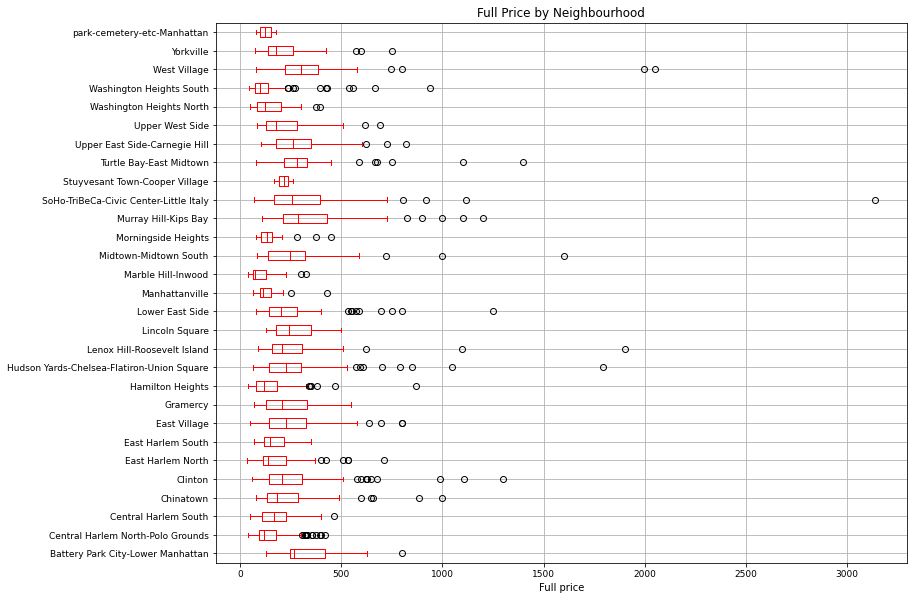

In [ ]:
bp = df_airbnb[['tab_area','full_price']].boxplot(column='full_price', by='tab_area',color='red',vert=False, fontsize=9, figsize=(12,10) )
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

**Remove Outliners**

In the above chart we can see some outliers - observation points that are distant from other observations.
In our case they are the indication of variance in the data.

In [ ]:
Q1 = df_airbnb['full_price'].quantile(0.25)
Q3 = df_airbnb['full_price'].quantile(0.75)
IQR = Q3 - Q1

filter = (df_airbnb['full_price'] >= Q1 - 1.5 * IQR) & (df_airbnb['full_price'] <= Q3 + 1.5 *IQR)
df_airbnb_norm = df_airbnb.loc[filter]  
df_airbnb_norm.shape

(2252, 28)

Text(0.5, 0.98, '')

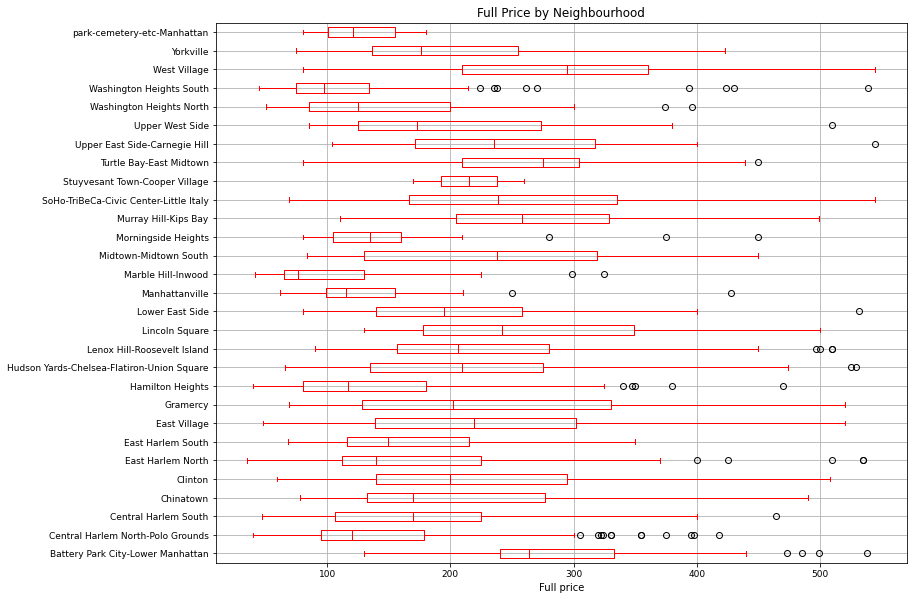

In [ ]:
bp = df_airbnb_norm[['tab_area','full_price']].boxplot(column='full_price', by='tab_area',color='red',vert=False, fontsize=9, figsize=(12,10))
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')


In this project we tried to detect Manhattan's Neighborhoods that have accommodations for rent with positive reviews, reasonable prices, low number of crimes and tourists' attractions nearby.

In the first step we collected the following data:


*   Airbnb Accommodations with their NYC Tabulation Area (official neighborhood names)
*   Airbnb Accommodation's number of crimes nearby
*  Defined NYC Tabulation Area (official neighborhood name) for each Manhattan's crime case.


The second step in our analysis will be a calculation and exploration different neighborhoods of Manhattan. We will explore the following characteristics:

*   number of crimes in the area
*   average price per person
*  number of accommodations available.

In third step we select Top-100 Airbnb accommodations based on:
*   Summary rating, number of crimes and price per person
*   Invoke Foursquare API to find Top accommodations' nearby venues
create
*   Investigate clusters ( k-means clustering) for our analysis to make some recommendations to our tourists.

###**4. Analysis**

We will explore our cleansed data set and visulize it. We will then conduct k-means cluster analysis to classify Manhattan's neighbourhood

**Average price per neighbourhood**

In [ ]:
neighbourhood_crime_price_merged = df_airbnb_norm.copy()
neighbourhood_crime_price_merged = neighbourhood_crime_price_merged.groupby("tab_area", as_index=False).agg({'crimes':'mean', 'price_per_person':'mean', 'accommodates':'count'})
neighbourhood_crime_price_merged.columns=['tab_area', 'mean_crimes', 'mean_price_per_person', 'accommodates']

In [ ]:
neighbourhood_crime_price_merged[['tab_area', 'mean_price_per_person', 'accommodates', 'mean_crimes']].sort_values('mean_price_per_person')

,tab_area,mean_price_per_person,accommodates,mean_crimes
15,Marble Hill-Inwood,45.475238,25,54.440000
25,Washington Heights South,46.793172,82,57.682927
24,Washington Heights North,54.738050,53,50.886792
1,Central Harlem North-Polo Grounds,57.038497,132,73.265152
14,Manhattanville,59.746667,25,70.520000
9,Hamilton Heights,60.069404,97,66.206186
28,park-cemetery-etc-Manhattan,61.404762,7,13.428571
5,East Harlem North,62.275497,91,104.824176
6,East Harlem South,64.950000,77,90.051948
2,Central Harlem South,67.000823,94,87.148936


Add New York Tabulation Areas Centroid latitude/longitude to our neighbourhood statistic data frame to display them on the map

In [ ]:

neighbourhood_crime_price_merged3 = neighbourhood_crime_price_merged.copy()
neighbourhood_crime_price_merged3 = neighbourhood_crime_price_merged3.merge(neighborhoods[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'tab_area', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])


**Apartments Total by Neighborhood Chart**

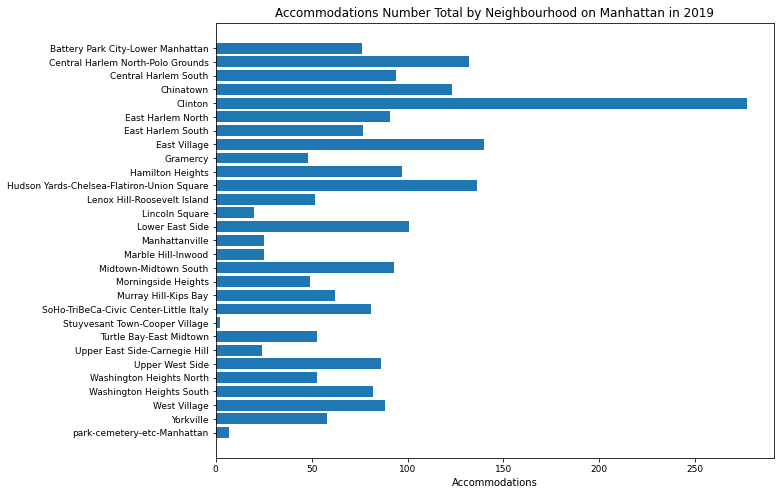

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
x = neighbourhood_crime_price_merged3.index
y = neighbourhood_crime_price_merged3.accommodates
xticks = neighbourhood_crime_price_merged3.tab_area
ax.barh(x, y)
ax.set_yticks(x)
ax.set_yticklabels(xticks)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accommodations')
ax.set_title('Accommodations Number Total by Neighbourhood on Manhattan in 2019')
plt.tick_params(labelsize=9)
plt.show()

**Crime summary by neighbourhood**

In [ ]:
df_manhattan_crime_neighbourhood = manhattan_crime.copy()
df_manhattan_crime_neighbourhood = df_manhattan_crime_neighbourhood.groupby("tab_area", as_index=False).agg({'CMPLNT_NUM':'count'})
df_manhattan_crime_neighbourhood.columns=['tab_area', 'crimes_summary']
df_manhattan_crime_neighbourhood.sort_values('crimes_summary')

,tab_area,crimes_summary
20,Stuyvesant Town-Cooper Village,145
28,park-cemetery-etc-Manhattan,1213
11,Lenox Hill-Roosevelt Island,1604
14,Manhattanville,1832
27,Yorkville,1898
15,Marble Hill-Inwood,1900
8,Gramercy,2021
17,Morningside Heights,2321
18,Murray Hill-Kips Bay,2333
7,East Village,2340


**Horizontal bar graph of neighbourhood crime records**

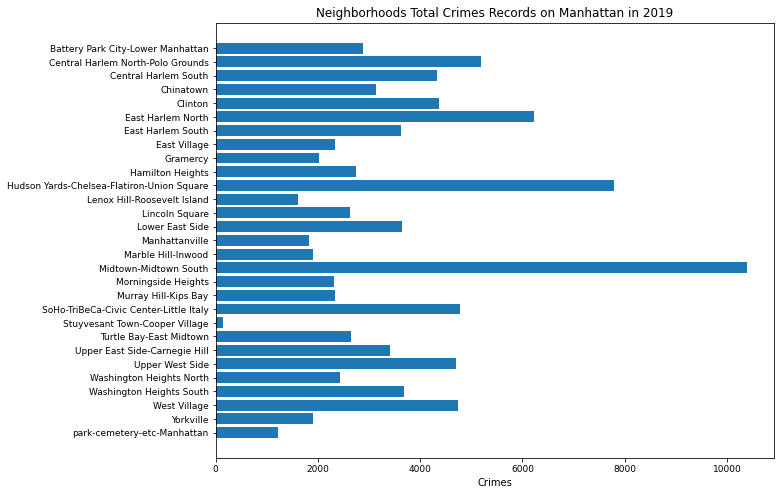

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
x = df_manhattan_crime_neighbourhood.index
y = df_manhattan_crime_neighbourhood.crimes_summary
xticks = df_manhattan_crime_neighbourhood.tab_area
ax.barh(x, y)
ax.set_yticks(x)
ax.set_yticklabels(xticks)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Crimes')
ax.set_title('Neighborhoods Total Crimes Records on Manhattan in 2019')
plt.tick_params(labelsize=9)
plt.show()

Adding Neighbourhood's Centroid latitude and longitude of the NYC Area Tabulation to the Crime data set

In [ ]:
df_manhattan_crime_neighbourhood2 = df_manhattan_crime_neighbourhood.copy()
df_manhattan_crime_neighbourhood2 = df_manhattan_crime_neighbourhood2.merge(neighborhoods[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'tab_area', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])
df_manhattan_crime_neighbourhood2.head()

,tab_area,crimes_summary,Latitude,Longitude
0,Battery Park City-Lower Manhattan,2883,40.706784,-74.010147
1,Central Harlem North-Polo Grounds,5186,40.819400,-73.941200
2,Central Harlem South,4320,40.802900,-73.952300
3,Chinatown,3137,40.715100,-73.995500
4,Clinton,4364,40.764423,-73.992392


**Analysis Map**

Now display Airbnb Neighborhoods prices per person on Manhattan in 2019.

Top-5 Neighborhoods with Highest Price per Person in 2019 year:

*    West Village - 112.85 USD  
*    Lincoln Square - 112.51 USD 
*    Stuyvesant Town-Cooper Village - 107.5 USD 
*    SoHo-TriBeCa-Civic Center-Little Italy - 105.38 USD 
*    Upper East Side-Carnegie Hill - 96.98 USD


Top-5 Neighborhoods with Lowest Price per Person in 2019 year:

*   Marble Hill-Inwood - 45.48 USD 
*   Washington Heights South - 46.79 USD
*   Washington Heights North - 54.74 USD 
*   Central Harlem North-Polo Grounds - 57 USD
*   Manhattanville - 59.75 USD 

In [ ]:
nyc_lat = 40.758896
nyc_lon = -73.985130
nyc_official_neighbourhoods_price_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
nyc_official_neighbourhoods_price_map.choropleth(
    geo_data=newyork_data,
    data=neighbourhood_crime_price_merged3,
    columns=['tab_area', 'mean_price_per_person'],
    key_on='properties.ntaname',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Price/Neighbourhoods in New York 2019')

# Add Official Neighbourhoods names
for lat, lng, poi, mean_price_per_person, accommodates, mean_crimes  in zip(neighbourhood_crime_price_merged3['Latitude'],
                                                                         neighbourhood_crime_price_merged3['Longitude'], 
                                                                         neighbourhood_crime_price_merged3['tab_area'],
                                                                         round(neighbourhood_crime_price_merged3['mean_price_per_person'],2), 
                                                                         neighbourhood_crime_price_merged3['accommodates'],
                                                                         round(neighbourhood_crime_price_merged3['mean_crimes'],2)):
    label = folium.Popup(str(poi) +  '|| Mean Price per person: $' + str(mean_price_per_person)  +', Accommodates Number: ' + str(accommodates)  + ', Mean Crimes: ' + str(mean_crimes), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_official_neighbourhoods_price_map)  
    
nyc_official_neighbourhoods_price_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Detailed info of accomodations

In [ ]:

df_airnb_norm_data = df_airnb_norm.iloc[:].copy()
accomodations = folium.map.FeatureGroup()
for lat, lng, poi, rating, full_price, price_per_person, accommodates, crimes, listing_url, picture_url, bathrooms, bedrooms,neighbourhood_cleansed,square_feet in zip(df_airnb_norm_data['latitude'],
                                                                         df_airnb_norm_data['longitude'], 
                                                                         df_airnb_norm_data['name'],
                                                                         df_airnb_norm_data['review_scores_rating'],
                                                                         round(df_airnb_norm_data['full_price'],2), 
                                                                         round(df_airnb_norm_data['price_per_person'],2), 
                                                                         df_airnb_norm_data['accommodates'],
                                                                         round(df_airnb_norm_data['crimes'],2),
                                                                         df_airnb_norm_data['listing_url'],
                                                                         df_airnb_norm_data['picture_url'],
                                                                         df_airnb_norm_data['bathrooms'],
                                                                         df_airnb_norm_data['bedrooms'],
                                                                         df_airnb_norm_data['neighbourhood_cleansed'],
                                                                         df_airnb_norm_data['square_feet']
                                                                        ):
    html = f"""
     <br /> 
     <b>Accommodation: </b>{poi} <br />  
     <b>Host: </b><a href='{listing_url}'>{listing_url}</a>  <br />  
     <b>Neighbourhood: </b> {neighbourhood_cleansed}<br />  
     <b>Rating: </b> {rating}<br />  
     <b>Full price (USD): </b>{full_price}  <br />   
     <b>Price per Person (USD): </b>{price_per_person} <br /> 
     <b>Accommodates: </b>{accommodates}<br /> 
     <b>Bathrooms: </b>{bathrooms}<br /> 
     <b>Bedrooms: </b>{bedrooms}<br /> 
     <b>Square feet: </b>{square_feet}<br /> 
     <b>Crimes in 100 meters: </b>{crimes} <br />      
     <img ALIGN="Right" src="{picture_url}" alt="Host picture" width="300"  height="100">
    """
    #label = folium.Popup(str(poi) +  '|| Full price: $' + str(full_price) + ', Price per person: $' + str(price_per_person)  +', Accommodates: ' + str(accommodates)  + ', Crimes: ' + str(crimes), parse_html=True)
    iframe = folium.IFrame(html=html, width=500, height=350) 
    popup = folium.Popup(iframe, max_width=500)
    accomodations.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=popup,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )     
nyc_official_neighbourhoods_price_map.add_child(accomodations)

**Crimes cluster map**

In [ ]:
nyc_crime_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=11)
limit = 1000
df_incidents = manhattan_crime.sample(limit) 

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(nyc_crime_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, area in zip(df_incidents.Latitude, df_incidents.Longitude, df_incidents.LAW_CAT_CD, df_incidents.tab_area):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
nyc_crime_map

**Summary Crimes by Neighborhoods **

Top-5 Neighborhoods with the Highest Crime level:

*  Midtown-Midtown South - 10,397
*  Hudson Yards-Chelsea-Flatiron-Union Square - 7,788
*  East Harlem North - 6,221
*  Central Harlem North-Polo Grounds - 5,186
*  SoHo-TriBeCa-Civic Center-Little Italy - 4,789


Top-5 Neighborhoods with the Lowest Crime level in 2019 year :

*  Stuyvesant Town-Cooper Village - 145
*  park-cemetery-etc-Manhattan - 1,213
*  Lenox Hill-Roosevelt Island - 1,604
*  Manhattanville - 1,832
*  Yorkville - 1,898

In [ ]:

nyc_lat = 40.758896
nyc_lon = -73.985130
nyc_official_neighbourhoods_crime_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
nyc_official_neighbourhoods_crime_map.choropleth(
    geo_data=newyork_data,
    data=df_manhattan_crime_neighbourhood2,
    columns=['tab_area', 'crimes_summary'],
    key_on='properties.ntaname',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime/Neighbourhoods in New York 2019')

# Add Official Neighbourhoods names
for lat, lng, poi, crimes_summary  in zip(df_manhattan_crime_neighbourhood2['Latitude'],
                                                                         df_manhattan_crime_neighbourhood2['Longitude'], 
                                                                         df_manhattan_crime_neighbourhood2['tab_area'],
                                                                         df_manhattan_crime_neighbourhood2['crimes_summary']
                                                                        ):
    label = folium.Popup(str(poi) +  '|| Crimes Summary: ' + str(crimes_summary), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#8B0000',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_official_neighbourhoods_crime_map)  
    

nyc_official_neighbourhoods_crime_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**Foursquare API Neighborhoods Analysis**

We choose Top accommodations by

*  review_scores_rating - overall accomodations rating - from maximum 100 to lower values
*  full_price - from lower price to higher
*  price_per_person - from lower price to higher
*  crimes - from lower number to higher

In [ ]:
limit=100
df_airnb_top = df_airnb_norm.sort_values(by=['review_scores_rating',  'full_price','price_per_person',  'crimes'], ascending=[False, True, True, True])[['name', 'tab_area', 'neighbourhood_cleansed','latitude', 'longitude' ,'review_scores_rating',  'property_type', 'room_type', 'accommodates', 'full_price', 'price_per_person', 'crimes', 'listing_url','picture_url','bathrooms', 'bedrooms','square_feet']].head(limit)

In [ ]:
df_airnb_top.head()

,name,tab_area,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,listing_url,picture_url,bathrooms,bedrooms,square_feet
2029,Private Bedroom in Cozy Hamilton Heights Apartment,Hamilton Heights,Harlem,40.82749,-73.94461,100.0,Apartment,Private room,2,54.0,27.0,34,https://www.airbnb.com/rooms/34770173,https://a0.muscache.com/im/pictures/aff6d2a3-b6f6-491f-84b3-1e6d2ff35115.jpg?aki_policy=large,1,1,0
1801,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,40.84377,-73.94094,100.0,Apartment,Private room,1,67.0,67.0,32,https://www.airbnb.com/rooms/32589616,https://a0.muscache.com/im/pictures/88aec7e7-eb04-417d-9c42-43a33d4b9426.jpg?aki_policy=large,1,1,0
1354,Cozy sanctuary/Big master bedroom/NYC/The Heights,Washington Heights North,Washington Heights,40.84911,-73.93097,100.0,Apartment,Private room,2,74.0,37.0,78,https://www.airbnb.com/rooms/26303788,https://a0.muscache.com/im/pictures/fcc9077f-fab7-4c8f-a62c-1b7340fcaa30.jpg?aki_policy=large,1,1,0
1529,Little Safe Haven,Hamilton Heights,Harlem,40.82494,-73.94280,100.0,Apartment,Private room,1,80.0,80.0,43,https://www.airbnb.com/rooms/29205817,https://a0.muscache.com/im/pictures/97143bde-79c7-4112-8bfa-fb219529c4e6.jpg?aki_policy=large,1,1,0
654,One cozy private BR close to the mecca of shopping,Turtle Bay-East Midtown,Midtown,40.76026,-73.96590,100.0,Apartment,Private room,1,80.0,80.0,64,https://www.airbnb.com/rooms/13246804,https://a0.muscache.com/im/pictures/b4722160-be37-4701-a2e5-36cfe38f7a27.jpg?aki_policy=large,1,2,0


In [ ]:
CLIENT_ID = 'O5AAPYYAN5LWZUZZUIONHRHP4OUT5GH20WRV5MPUBHJYFB13' 
CLIENT_SECRET = 'AA1H0P1QEPBNZY2LKTHAEICPGBJKUMTKF2JSI34UFC2I1MA0' 
VERSION = '20180605' # Foursquare API version
LIMIT = 50
RADIUS = 1000

In [ ]:
def getAccomodatesNearbyVenues(names, latitudes, longitudes, radius, limit):
    venues_list=[]
    nearby_venues = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        try:
            response = requests.get(url)
            if response.status_code == 200: 
                results = response.json()["response"]['groups'][0]['items']
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])

                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['name', 
                                         'latitude', 
                                         'longitude', 
                                         'Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']
            else:
                print ("Exception during call URL={} , Code={}, Text={}".format(url, response.status_code, response.text))
        except Exception as e:
            print ("Exception: {}".format(e))
            raise e
    
    return(nearby_venues)

In [ ]:
df_airnb_top_venues = getAccomodatesNearbyVenues(names=df_airnb_top['name'],
                                   latitudes=df_airnb_top['latitude'],
                                   longitudes=df_airnb_top['longitude'],
                                   radius = RADIUS,
                                   limit = LIMIT
                                  )

Private Bedroom in Cozy Hamilton Heights Apartment
Mr. B - Room Apartment in NYC
Cozy sanctuary/Big master bedroom/NYC/The Heights
Little Safe Haven
One cozy private BR close to the mecca of shopping
Spacious and Modern Hideout | Close to Everything
Master Suite near NYP/CUMC and 2 blks from Subway
Gorgeous Manhattan Hideout | Close to Everything
Old School New York
157-C
Large UWS Private Bedroom with Outdoor Space
Park-lovers Paradise in Central Manhattan
A neat bedroom in a cozy 3-bedroom apartment
Massive sun filled room on Central Park West.
airy, earthy room in artistic apt
U W S Sunny Queen size bedroom near Columbia UNI*
Luxury Street View Room 2 blocks from Times Square
Huge modern room in a cozy sunny home
Beautiful, sunlit private room in Spanish Harlem
Spacious & bright apartment in the heart of Harlem
Contemporary bedroom in a cozy sunny home
Bright Bohemian Gem in the Lower East Side
Nice private room in quiet E Village apt
Spanish Harlem magical place. Mezzanine bed
Spac

In [ ]:
df_airnb_top_venues.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Branson Got Juice!,40.825525,-73.943681,Juice Bar
1,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Harlem Public,40.828803,-73.948685,Bar
2,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Buddha Taco Bar,40.829007,-73.948089,Bar
3,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Monkey Cup,40.825694,-73.947234,Coffee Shop
4,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,The Honeywell,40.828549,-73.948739,Speakeasy


**Custom top level categories**

In [ ]:
fine_art_cat = ['Art','Arts','Museum', 'Library','Exhibit','Gallery']
eat_place_cat = ['Restaurant','Steakhouse']
shopping_cat = ['Shopping Mall','Market','Boutique']
outdoor_cat = ['Sculpture Garden','Scenic Lookout','Roof Deck','Outdoor Sculpture','Monument / Landmark',
               'Memorial Site','Lighthouse','Historic Site','Harbor / Marina','Fountain','Event Space','Bridge',
               'Waterfront','Church','Building','Garden','Historic Site','Lake','Park',
               'Pier','Rest Area','River','Synagogue','Field']
entertainment_cat = ['Nightclub','Circus','Club', 'Stadium', 'Karaoke Bar', 'Pub','Theater','Opera', 'Concert', 'Zoo']

#Join all categories' values in one
tourists_categories = fine_art_cat + eat_place_cat + shopping_cat + outdoor_cat +entertainment_cat


# We need Venues only from our Custom Categories
def check(category):
    if any(word in category for word in tourists_categories):
        return True
    return False

# Define Category
def change_categoty(name):
    if any(word in name for word in entertainment_cat):
        return 'Entertainment'
    if any(word in name for word in fine_art_cat):
        return 'Fine Art'
    if any(word in name for word in eat_place_cat):
        return 'Food Place'
    if any(word in name for word in shopping_cat):        
        return 'Shopping'
    if any(word in name for word in outdoor_cat):            
        return 'Sightseeing'
    if any(word in name for word in tansportation_cat):            
        return 'Transportation'


# Define Top Venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:num_top_venues] 

def return_most_common_venues_stats(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:num_top_venues]

#Keep only tourist categories
df_airnb_top_venues_f = df_airnb_top_venues[df_airnb_top_venues['Venue Category'].apply(lambda x: check(x))].copy()
df_airnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Wat’s On Your Plate,40.825632,-73.948494,Caribbean Restaurant
6,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Barepas,40.827717,-73.946173,Arepa Restaurant
7,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Bono Trattoria,40.830180,-73.947420,Italian Restaurant
8,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Convent Garden,40.828560,-73.942531,Garden
12,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Riverside Drive Running Path,40.827738,-73.942124,Scenic Lookout


Add venue category

In [ ]:
df_airnb_top_venues_f.rename(columns = {'Venue Category':'Venue Type'}, inplace = True)
df_airnb_top_venues_f['Venue Category'] = df_airnb_top_venues_f['Venue Type'].apply(lambda x: change_categoty(x))
df_airnb_top_venues_f.head()

,name,latitude,longitude,Venue,Venue Latitude,Venue Longitude,Venue Type,Venue Category
5,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Wat’s On Your Plate,40.825632,-73.948494,Caribbean Restaurant,Food Place
6,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Barepas,40.827717,-73.946173,Arepa Restaurant,Food Place
7,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Bono Trattoria,40.830180,-73.947420,Italian Restaurant,Food Place
8,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Convent Garden,40.828560,-73.942531,Garden,Sightseeing
12,Private Bedroom in Cozy Hamilton Heights Apartment,40.82749,-73.94461,Riverside Drive Running Path,40.827738,-73.942124,Scenic Lookout,Sightseeing


**Display the Top-3 Venues Categories for each accommodation**

In [ ]:
# one hot encoding
airnb_onehot = pd.get_dummies(df_airnb_top_venues_f[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
airnb_onehot['name'] = df_airnb_top_venues_f['name'] 

# move name column to the first column
fixed_columns = [airnb_onehot.columns[-1]] + list(airnb_onehot.columns[:-1])
airnb_onehot = airnb_onehot[fixed_columns]


airnb_grouped = (np.round(airnb_onehot.groupby('name').mean(),2)).reset_index()
airnb_grouped.head()

,name,Entertainment,Fine Art,Food Place,Shopping,Sightseeing
0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",0.36,0.00,0.64,0.00,0.00
1,157-C,0.04,0.12,0.58,0.00,0.25
2,A neat bedroom in a cozy 3-bedroom apartment,0.03,0.03,0.45,0.03,0.45
3,Art filled peaceful paradise EV Union Square,0.17,0.00,0.67,0.08,0.08
4,Artsy Parisian Apt in Greenwich Village,0.25,0.00,0.65,0.00,0.10


In [ ]:
# Find Top-3 Venues Category
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create a new dataframe
airnb_venues_sorted = pd.DataFrame(columns=columns)
airnb_venues_sorted['name'] = airnb_grouped['name']

for ind in np.arange(airnb_grouped.shape[0]):
    strings_stats = np.around(return_most_common_venues_stats(airnb_grouped.iloc[ind, :], num_top_venues),2) 
    strings_category = return_most_common_venues(airnb_grouped.iloc[ind, :], num_top_venues)
    airnb_venues_sorted.iloc[ind, 1:] = np.concatenate([strings_category,strings_stats ])

airnb_venues_sorted.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Food Place,Entertainment,Sightseeing,0.64,0.36,0
1,157-C,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
2,A neat bedroom in a cozy 3-bedroom apartment,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
3,Art filled peaceful paradise EV Union Square,Food Place,Entertainment,Sightseeing,0.67,0.17,0.08
4,Artsy Parisian Apt in Greenwich Village,Food Place,Entertainment,Sightseeing,0.65,0.25,0.1


**K-means Clustering**

In [ ]:
kclusters = 3

airnb_grouped_clustering = airnb_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(airnb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 2, 1, 1, 1, 1, 2, 2, 1], dtype=int32)

In [ ]:
airnb_venues_clustered = airnb_venues_sorted.copy()
airnb_venues_clustered.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Food Place,Entertainment,Sightseeing,0.64,0.36,0
1,157-C,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
2,A neat bedroom in a cozy 3-bedroom apartment,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
3,Art filled peaceful paradise EV Union Square,Food Place,Entertainment,Sightseeing,0.67,0.17,0.08
4,Artsy Parisian Apt in Greenwich Village,Food Place,Entertainment,Sightseeing,0.65,0.25,0.1


In [ ]:
airnb_venues_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
airnb_venues_clustered.head()

,Cluster Labels,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
0,0,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Food Place,Entertainment,Sightseeing,0.64,0.36,0
1,2,157-C,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
2,2,A neat bedroom in a cozy 3-bedroom apartment,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
3,1,Art filled peaceful paradise EV Union Square,Food Place,Entertainment,Sightseeing,0.67,0.17,0.08
4,1,Artsy Parisian Apt in Greenwich Village,Food Place,Entertainment,Sightseeing,0.65,0.25,0.1


In [ ]:
airnb_merged = df_airnb_top.copy()
#  add latitude/longitude 
airnb_merged  = airnb_merged.join(airnb_venues_clustered.set_index('name'), on='name')
airnb_merged = airnb_merged.dropna()
airnb_merged.head()

,name,tab_area,neighbourhood_cleansed,latitude,longitude,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,listing_url,picture_url,bathrooms,bedrooms,square_feet,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
2029,Private Bedroom in Cozy Hamilton Heights Apartment,Hamilton Heights,Harlem,40.82749,-73.94461,100.0,Apartment,Private room,2,54.0,27.0,34,https://www.airbnb.com/rooms/34770173,https://a0.muscache.com/im/pictures/aff6d2a3-b6f6-491f-84b3-1e6d2ff35115.jpg?aki_policy=large,1,1,0,2.0,Food Place,Sightseeing,Fine Art,0.67,0.28,0.06
1801,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,40.84377,-73.94094,100.0,Apartment,Private room,1,67.0,67.0,32,https://www.airbnb.com/rooms/32589616,https://a0.muscache.com/im/pictures/88aec7e7-eb04-417d-9c42-43a33d4b9426.jpg?aki_policy=large,1,1,0,1.0,Food Place,Sightseeing,Shopping,0.75,0.2,0.05
1354,Cozy sanctuary/Big master bedroom/NYC/The Heights,Washington Heights North,Washington Heights,40.84911,-73.93097,100.0,Apartment,Private room,2,74.0,37.0,78,https://www.airbnb.com/rooms/26303788,https://a0.muscache.com/im/pictures/fcc9077f-fab7-4c8f-a62c-1b7340fcaa30.jpg?aki_policy=large,1,1,0,1.0,Food Place,Sightseeing,Shopping,0.78,0.19,0.04
1529,Little Safe Haven,Hamilton Heights,Harlem,40.82494,-73.94280,100.0,Apartment,Private room,1,80.0,80.0,43,https://www.airbnb.com/rooms/29205817,https://a0.muscache.com/im/pictures/97143bde-79c7-4112-8bfa-fb219529c4e6.jpg?aki_policy=large,1,1,0,1.0,Food Place,Sightseeing,Fine Art,0.74,0.16,0.11
654,One cozy private BR close to the mecca of shopping,Turtle Bay-East Midtown,Midtown,40.76026,-73.96590,100.0,Apartment,Private room,1,80.0,80.0,64,https://www.airbnb.com/rooms/13246804,https://a0.muscache.com/im/pictures/b4722160-be37-4701-a2e5-36cfe38f7a27.jpg?aki_policy=large,1,2,0,1.0,Food Place,Entertainment,Sightseeing,0.69,0.12,0.06


Display NYC Tab Areas and Airnbnb Neighborhoods Names

In [ ]:
df_airnb_norm.groupby(['tab_area','neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('NYC Tab Area')

,NYC Tab Area,Airbnb Neighbourhood,Count
0,Battery Park City-Lower Manhattan,Battery Park City,1
1,Battery Park City-Lower Manhattan,Financial District,75
2,Central Harlem North-Polo Grounds,East Harlem,15
3,Central Harlem North-Polo Grounds,Harlem,117
4,Central Harlem South,Harlem,94
5,Chinatown,Chinatown,48
6,Chinatown,Civic Center,1
7,Chinatown,Lower East Side,60
8,Chinatown,Two Bridges,14
9,Clinton,Hell's Kitchen,277


Top Airbnb's Accommodations Proposals by NYC Tab Area Names

In [ ]:
df_airnb_norm.groupby(['tab_area']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area'}).sort_values('Count', ascending = False)

,NYC Tab Area,Count
4,Clinton,277
7,East Village,140
10,Hudson Yards-Chelsea-Flatiron-Union Square,136
1,Central Harlem North-Polo Grounds,132
3,Chinatown,123
13,Lower East Side,101
9,Hamilton Heights,97
2,Central Harlem South,94
16,Midtown-Midtown South,93
5,East Harlem North,91


Top Airbnb's Accommodations Proposals by Airbnb Neighborhoods Names

In [ ]:
df_airnb_norm.groupby(['neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('Count', ascending = False)

,Airbnb Neighbourhood,Count
10,Harlem,336
11,Hell's Kitchen,335
5,East Village,197
4,East Harlem,183
29,Upper West Side,136
30,Washington Heights,128
28,Upper East Side,127
17,Midtown,106
15,Lower East Side,100
1,Chelsea,93


**Examining our Clusters**

In [ ]:
nyc_lat = 40.758896
nyc_lon = -73.985130
map_clusters = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
accomodations_cl = folium.map.FeatureGroup()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, poi, rating, full_price, price_per_person, accommodates, crimes, listing_url, picture_url, bathrooms, bedrooms,neighbourhood_cleansed,square_feet, cluster in zip(airnb_merged['latitude'],
                                                                         airnb_merged['longitude'], 
                                                                         airnb_merged['name'],
                                                                         airnb_merged['review_scores_rating'],
                                                                         round(airnb_merged['full_price'],2), 
                                                                         round(airnb_merged['price_per_person'],2), 
                                                                         airnb_merged['accommodates'],
                                                                         round(airnb_merged['crimes'],2),
                                                                         airnb_merged['listing_url'],
                                                                         airnb_merged['picture_url'],
                                                                         airnb_merged['bathrooms'],
                                                                         airnb_merged['bedrooms'],
                                                                         airnb_merged['neighbourhood_cleansed'],
                                                                         airnb_merged['square_feet'],
                                                                         airnb_merged['Cluster Labels'].astype(int)):
    html_cl = f"""
     <br /> 
     <b>Cluster: </b>{cluster} <br />  
     <b>Accommodation: </b>{poi} <br />  
     <b>Host: </b><a href='{listing_url}'>{listing_url}</a>  <br />  
     <b>Neighbourhood: </b> {neighbourhood_cleansed}<br />  
     <b>Rating: </b> {rating}<br />  
     <b>Full price (USD): </b>{full_price}  <br />   
     <b>Price per Person (USD): </b>{price_per_person} <br /> 
     <b>Accommodates: </b>{accommodates}<br /> 
     <b>Bathrooms: </b>{bathrooms}<br /> 
     <b>Bedrooms: </b>{bedrooms}<br /> 
     <b>Square feet: </b>{square_feet}<br /> 
     <b>Crimes in 100 meters: </b>{crimes} <br />      
     <img ALIGN="Right" src="{picture_url}" alt="Host picture" width="300"  height="100">
    """
    iframe_cl = folium.IFrame(html=html_cl, width=500, height=350) 
    popup = folium.Popup(iframe_cl, max_width=500)
    accomodations_cl.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=popup,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7
        )
    )     
map_clusters.add_child(accomodations_cl)

**Culster 0**

In [ ]:
cluster0 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 0, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster0.describe()


,review_scores_rating,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,14.0,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.0
mean,100.0,2.571429,271.857143,114.003571,97.500000,1.0,0.785714,0.0
std,0.0,1.157868,99.578231,40.551631,64.313834,0.0,0.425815,0.0
min,100.0,1.000000,110.000000,55.000000,23.000000,1.0,0.000000,0.0
25%,100.0,2.000000,192.500000,83.225000,60.000000,1.0,1.000000,0.0
50%,100.0,2.000000,272.500000,113.750000,74.000000,1.0,1.000000,0.0
75%,100.0,3.500000,339.750000,138.750000,112.000000,1.0,1.000000,0.0
max,100.0,5.000000,420.000000,200.000000,257.000000,1.0,1.000000,0.0


In [ ]:
cluster0

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
2352,Luxury Street View Room 2 blocks from Times Square,Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,110.0,55.00,64,1,1,0.0,Entertainment,Food Place,Fine Art,0.58,0.38,0.04
2152,Studio (200 sq ft.) near Times Square!,Clinton,Hell's Kitchen,100.0,Apartment,Entire home/apt,1,154.0,154.00,89,1,0,0.0,Entertainment,Food Place,Fine Art,0.56,0.37,0.07
997,Experience the heart of Hell's Kitchen.,Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,155.0,77.50,41,1,1,0.0,Food Place,Entertainment,Fine Art,0.63,0.33,0.04
675,"Superhost Chelsea Large, Private, Quiet bedroom",Hudson Yards-Chelsea-Flatiron-Union Square,Chelsea,100.0,Apartment,Private room,2,175.0,87.50,59,1,1,0.0,Fine Art,Food Place,Sightseeing,0.38,0.29,0.14
1059,"Midtown near Times Square, Broadway & Central Park",Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,245.0,122.50,56,1,1,0.0,Food Place,Entertainment,Sightseeing,0.61,0.39,0
904,PRIVATE BATH next to Central Park!,Clinton,Hell's Kitchen,100.0,Apartment,Private room,2,254.0,127.00,23,1,1,0.0,Food Place,Entertainment,Fine Art,0.63,0.32,0.05
1448,"**Stylish, Quiet, Centrally Located (9th & 52nd)",Clinton,Hell's Kitchen,100.0,Condominium,Private room,2,270.0,135.00,114,1,1,0.0,Food Place,Entertainment,Sightseeing,0.64,0.36,0
1568,DESIGNER 1 BEDROOM APARTMENT,Clinton,Hell's Kitchen,100.0,Apartment,Entire home/apt,4,275.0,68.75,147,1,1,0.0,Entertainment,Food Place,Fine Art,0.56,0.36,0.08
1254,High End Hilton Club in midtown Manhattan,Midtown-Midtown South,Midtown,100.0,Serviced apartment,Entire home/apt,2,280.0,140.00,63,1,0,0.0,Food Place,Entertainment,Fine Art,0.59,0.23,0.14
1705,Modern 1 Bedroom Escape with River Views,Clinton,Hell's Kitchen,100.0,Condominium,Entire home/apt,2,309.0,154.50,74,1,1,0.0,Food Place,Entertainment,Fine Art,0.53,0.35,0.12


Check NYC Tab Area names

In [ ]:
sorted(cluster0.tab_area.unique())

['Clinton',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Midtown-Midtown South']

In [ ]:
sorted(cluster0.neighbourhood_cleansed.unique())

['Chelsea', "Hell's Kitchen", 'Midtown']

**Cluster 1**

In [ ]:

cluster1 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 1, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster1.describe()

,review_scores_rating,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0
mean,100.0,2.188679,224.735849,107.483648,67.679245,1.018868,1.037736,1.0
std,0.0,0.899927,115.623752,46.925600,60.008260,0.239436,0.436871,0.0
min,100.0,1.000000,67.000000,37.000000,3.000000,0.000000,0.000000,1.0
25%,100.0,2.000000,139.000000,70.000000,38.000000,1.000000,1.000000,1.0
50%,100.0,2.000000,195.000000,98.333333,51.000000,1.000000,1.000000,1.0
75%,100.0,3.000000,295.000000,137.500000,78.000000,1.000000,1.000000,1.0
max,100.0,5.000000,519.000000,259.500000,385.000000,2.000000,2.000000,1.0


In [ ]:
cluster1

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
1801,Mr. B - Room Apartment in NYC,Washington Heights South,Washington Heights,100.0,Apartment,Private room,1,67.0,67.000000,32,1,1,1.0,Food Place,Sightseeing,Shopping,0.75,0.2,0.05
1354,Cozy sanctuary/Big master bedroom/NYC/The Heights,Washington Heights North,Washington Heights,100.0,Apartment,Private room,2,74.0,37.000000,78,1,1,1.0,Food Place,Sightseeing,Shopping,0.78,0.19,0.04
1529,Little Safe Haven,Hamilton Heights,Harlem,100.0,Apartment,Private room,1,80.0,80.000000,43,1,1,1.0,Food Place,Sightseeing,Fine Art,0.74,0.16,0.11
654,One cozy private BR close to the mecca of shopping,Turtle Bay-East Midtown,Midtown,100.0,Apartment,Private room,1,80.0,80.000000,64,1,2,1.0,Food Place,Entertainment,Sightseeing,0.69,0.12,0.06
1694,Master Suite near NYP/CUMC and 2 blks from Subway,Washington Heights South,Washington Heights,100.0,Apartment,Private room,2,85.0,42.500000,64,0,1,1.0,Food Place,Sightseeing,Shopping,0.8,0.15,0.05
2216,Large UWS Private Bedroom with Outdoor Space,Upper West Side,Upper West Side,100.0,Apartment,Private room,2,90.0,45.000000,32,1,1,1.0,Food Place,Sightseeing,Entertainment,0.81,0.11,0.07
2118,Huge modern room in a cozy sunny home,Central Harlem South,Harlem,100.0,Apartment,Private room,2,110.0,55.000000,69,2,1,1.0,Food Place,Entertainment,Fine Art,0.62,0.17,0.12
2240,Spacious & bright apartment in the heart of Harlem,Central Harlem North-Polo Grounds,Harlem,100.0,Apartment,Private room,3,120.0,40.000000,232,1,1,1.0,Food Place,Sightseeing,Fine Art,0.62,0.12,0.12
2119,Contemporary bedroom in a cozy sunny home,Central Harlem South,Harlem,100.0,Apartment,Private room,2,120.0,60.000000,33,2,1,1.0,Food Place,Entertainment,Shopping,0.59,0.18,0.09
2100,Bright Bohemian Gem in the Lower East Side,Chinatown,Chinatown,100.0,Apartment,Entire home/apt,2,120.0,60.000000,56,1,1,1.0,Food Place,Entertainment,Sightseeing,0.77,0.12,0.04


In [ ]:
sorted(cluster1.tab_area.unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Village',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lower East Side',
 'Morningside Heights',
 'Murray Hill-Kips Bay',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Turtle Bay-East Midtown',
 'Upper East Side-Carnegie Hill',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville']

In [ ]:
sorted(cluster1.neighbourhood_cleansed.unique())

['Chelsea',
 'Chinatown',
 'East Harlem',
 'East Village',
 'Financial District',
 'Gramercy',
 'Greenwich Village',
 'Harlem',
 "Hell's Kitchen",
 'Lower East Side',
 'Midtown',
 'Murray Hill',
 'Nolita',
 'SoHo',
 'Upper East Side',
 'Upper West Side',
 'Washington Heights',
 'West Village']

**Cluster 2**

In [ ]:
cluster2 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 2, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster2.describe()

,review_scores_rating,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0
mean,99.937500,3.000000,196.593750,70.023438,64.312500,1.218750,1.093750,2.0
std,0.245935,1.883716,120.127851,37.941937,41.871876,0.490844,0.465547,0.0
min,99.000000,1.000000,54.000000,27.000000,4.000000,1.000000,0.000000,2.0
25%,100.000000,2.000000,90.000000,47.375000,35.500000,1.000000,1.000000,2.0
50%,100.000000,2.000000,166.500000,63.000000,58.000000,1.000000,1.000000,2.0
75%,100.000000,4.000000,263.250000,72.250000,83.250000,1.000000,1.000000,2.0
max,100.000000,10.000000,470.000000,225.000000,175.000000,3.000000,3.000000,2.0


In [ ]:
cluster2

,name,tab_area,neighbourhood_cleansed,review_scores_rating,property_type,room_type,accommodates,full_price,price_per_person,crimes,bathrooms,bedrooms,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,1st Most Common Venue Share,2nd Most Common Venue Share,3rd Most Common Venue Share
2029,Private Bedroom in Cozy Hamilton Heights Apartment,Hamilton Heights,Harlem,100.0,Apartment,Private room,2,54.0,27.000000,34,1,1,2.0,Food Place,Sightseeing,Fine Art,0.67,0.28,0.06
2130,Spacious and Modern Hideout | Close to Everything,Hamilton Heights,Harlem,100.0,Apartment,Private room,2,85.0,42.500000,47,1,1,2.0,Food Place,Sightseeing,Fine Art,0.57,0.24,0.14
2129,Gorgeous Manhattan Hideout | Close to Everything,Hamilton Heights,Harlem,100.0,Apartment,Private room,2,85.0,42.500000,66,1,1,2.0,Food Place,Sightseeing,Fine Art,0.62,0.19,0.14
1219,Old School New York,Upper West Side,Upper West Side,100.0,Apartment,Private room,2,87.0,43.500000,4,1,1,2.0,Food Place,Sightseeing,Entertainment,0.67,0.28,0.06
2339,157-C,Washington Heights South,Washington Heights,100.0,Apartment,Private room,2,87.0,43.500000,14,1,1,2.0,Food Place,Sightseeing,Fine Art,0.58,0.25,0.12
1214,Park-lovers Paradise in Central Manhattan,Central Harlem South,Harlem,100.0,Apartment,Private room,2,90.0,45.000000,76,2,1,2.0,Food Place,Sightseeing,Shopping,0.59,0.26,0.07
1627,A neat bedroom in a cozy 3-bedroom apartment,Lenox Hill-Roosevelt Island,Roosevelt Island,100.0,Apartment,Private room,1,90.0,90.000000,23,1,1,2.0,Sightseeing,Food Place,Shopping,0.45,0.45,0.03
2232,Massive sun filled room on Central Park West.,Morningside Heights,Upper West Side,100.0,Apartment,Private room,2,95.0,47.500000,32,1,1,2.0,Food Place,Sightseeing,Shopping,0.59,0.37,0.04
384,"airy, earthy room in artistic apt",Washington Heights North,Washington Heights,100.0,Apartment,Private room,1,100.0,100.000000,82,1,1,2.0,Food Place,Sightseeing,Shopping,0.73,0.23,0.05
1804,U W S Sunny Queen size bedroom near Columbia UNI*,Upper West Side,Upper West Side,100.0,Apartment,Private room,2,110.0,55.000000,36,2,1,2.0,Food Place,Sightseeing,Shopping,0.61,0.35,0.04


In [ ]:
sorted(cluster2.tab_area.unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'East Harlem North',
 'East Harlem South',
 'Hamilton Heights',
 'Lenox Hill-Roosevelt Island',
 'Marble Hill-Inwood',
 'Morningside Heights',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village']

In [ ]:
sorted(cluster2.neighbourhood_cleansed.unique())

['East Harlem',
 'Financial District',
 'Harlem',
 'Inwood',
 'Morningside Heights',
 'Roosevelt Island',
 'Upper West Side',
 'Washington Heights',
 'West Village']

###**5. Result and discussion**

The analysis defined 3 clusters
All clusters have a 'Food Place' category as the first Common Venues. This is  common among the clusters defines clusters.
But they are distinguished by the other characteristics as

*  Average price per person
*  Average crimes Rate
*  The second common Venues
*  Number of available Airbnb accommodations
*  Neighborhoods location

**Cluster 0** - 
This is the smallest cluster with the following particular qualities (Nightclub, Stadium, Pub, Theater, Concert and so on):

*  highest average price_per_person among all clusters - $111
*  highest average crimes rate among all clusters - 102
*   is 1st and the 2nd Top Common Venue Categories
*  contains 15% from all top accommodations (Top-100 Airbnb accommodations)
*  spreads on Chelsea, Hell's Kitchen, and Midtown Airbnb's Neighborhoods.

**Cluster 1** :
It contains
*  average price_per_person - $110
*  average crimes rate - 67 
*  mix of all Venue Categories 
*  contains 58% from all accommodations selected from analysis (Top-100 Airbnb accommodations)
*  spreads almost on all Manhattan's areas.

**Cluster 2**  Sightseeing is the cheapest one with many Sightseeing attractions nearby 

*  lowest average price_per_person - $59
*  lowest crimes rate among all clusters - 65
*  Sightseeing is the second top Common Venue Category
*  contains 27% from all top accommodations (Top-100 Airbnb accommodations)
*  spreads on East Harlem, Financial District, Harlem, Inwood, Morningside   Heights, Roosevelt Island, Upper West Side, Washington Heights, West Village.
*  We identified three clusters from which a visitor could choose an appropriate accommodation based on his/her preferences or needs.

**Top Neighborhoods Statistics**

Top-5 Manhattan Tab Area (Airbnb Neighborhoods) with Lowest Average Price per Person in 2019 year:

*  Marble Hill-Inwood (Marble Hill, Inwood)- 45.48 USD - 25 accommodations
*  Washington Heights South (Washington Heights)- 46.79 USD - 82 accommodations
*  Washington Heights North (Inwood, Washington Heights)- 54.74 USD - 53 accommodations
*  Central Harlem North-Polo Grounds (Harlem, East Harlem)- 57.00 USD - 132 accommodations
*  Manhattanville (Harlem)- 59.75 USD - 25 accommodations


Top-5 Manhattan Tab Area (Airbnb Neighborhoods) with the Lowest Crime level in 2019 year :

*  Stuyvesant Town-Cooper Village (Stuyvesant Town)                    -145
*  park-cemetery-etc-Manhattan (Inwood, Washington Heights)      - 1,213
*  Lenox Hill-Roosevelt Island (Roosevelt Island, Upper East Side)  - 1,604
*  Manhattanville (Harlem)                                                           - 1,832
* Yorkville (Upper East Side)                                                      - 1,898

**Note**

*  Our analysis was limited to Manhattan Brugh's only
*  Foursquare developer account has a limitation of 950 calls/day so maybe it's worth to upgrade our free account to analyze Top-1000 Airbnb accommodations instead of Top-100.



###**6. Conclusion**

 The basic data analysis was performed to identify Manhattan's Neighborhoods clusters for a short stay visit.
During the analysis, we cleaned and investigated Manhattan Neighborhoods' datasets, found some statistical characteristics and visualize them.

The aim of this project is to help Manhattan visitors select the Airbnb neighborhoods where to stay based on the most common venues, price policy, and safety characteristics:

*  If a person is interested in Entertainment (Nightlife, Pubs, Concerts, Movies) we recommend paying attention for accommodations from the Cluster 0 - *  Entertainment: Chelsea, Hell's Kitchen, and Midtown Airbnb's Neighborhoods. But the person should take into the consideration the high prices and crime rate for this location
*  if a person is looking for a neighborhood with lower prices and nice views nearby we recommend looking at Cluster 2 - Sightseeing: Chelsea, Hell's Kitchen, and Midtown Airbnb's Neighborhoods
*  if a person does not have any preferences - investigate proposals from Cluster 1 - Mix. It has average prices and spreads over almost all Manhattan's neighborhoods.

Thank you
Author: Ieesha Deshmukh